In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.linear_model import LinearRegression
from fill_data_gap_helpers import *

pd.set_option('display.max_rows', 8)
!

%load_ext autoreload
%autoreload 2

## Load data

In [2]:
path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/lsff_estimated_data_plus_covariates_with_nutrient_3_22_2021.csv'
# path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/lsff_estimated_data_plus_covariates_3_14_2021.csv'

In [3]:
df = pd.read_csv(path)
df = df[['location_id','location_name', 'vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_vehicle', 'nutrient',
       'percent_of_population_eating_fortified_vehicle',
       'sodium', 'whole_grains', 'sdi', 'hh_salt', 'fao_maize_and_products',
       'fao_rice_and_products', 'fao_wheat_and_products', 'fao_oil_all',
       'parent_id']]
df.head()

,location_id,location_name,vehicle,percent_of_population_eating_industrially_produced_vehicle,percent_of_population_eating_vehicle,nutrient,percent_of_population_eating_fortified_vehicle,sodium,whole_grains,sdi,hh_salt,fao_maize_and_products,fao_rice_and_products,fao_wheat_and_products,fao_oil_all,parent_id
0,161.0,Bangladesh,oil,88.4,95.0,vitamin a,42.849572,1.8698,30.645066,0.475232,0.809817,7.0,1728.0,164.0,178.0,159
1,161.0,Bangladesh,oil,88.4,95.0,vitamin d,0.000000,1.8698,30.645066,0.475232,0.809817,7.0,1728.0,164.0,178.0,159
2,161.0,Bangladesh,oil,88.4,89.0,vitamin a,42.849572,1.8698,30.645066,0.475232,0.809817,7.0,1728.0,164.0,178.0,159
3,161.0,Bangladesh,oil,88.4,89.0,vitamin d,0.000000,1.8698,30.645066,0.475232,0.809817,7.0,1728.0,164.0,178.0,159
4,161.0,Bangladesh,oil,88.4,75.0,vitamin a,42.849572,1.8698,30.645066,0.475232,0.809817,7.0,1728.0,164.0,178.0,159


In [4]:
all_locs = set(df.location_name)

In [5]:
df[(df.vehicle=="maize flour") & (df.percent_of_population_eating_vehicle.notna())].location_name.unique()

array(['Kenya', 'Nigeria', 'South Africa', 'Uganda',
       'United Republic of Tanzania', 'Burkina Faso',
       'Democratic Republic of the Congo', 'Mozambique'], dtype=object)

In [6]:
missing_maize_locs = all_locs.difference(df[(df.vehicle=="maize flour") & (df.percent_of_population_eating_vehicle.notna())].location_name)

In [7]:
maize_est_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/pct_eating_maize_regression_estimates_3_22_2021.csv'
pct_eating_maize = pd.read_csv(maize_est_path)

draws = [f'draw_{i}' for i in range(1_000)]

pct_eating_maize = pct_eating_maize.groupby(['location_name','vehicle']).mean().reset_index()

In [8]:
pct_eating_maize

,location_name,vehicle,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,draw_6,draw_7,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Angola,maize flour,56.397130,49.601774,53.121598,52.740807,52.502517,54.217744,52.999897,52.246844,...,54.226776,53.669017,50.035151,53.223550,51.865269,44.375472,54.358987,50.879788,52.229135,49.681227
1,Burkina Faso,maize flour,31.150000,31.150000,31.150000,31.150000,31.150000,31.150000,31.150000,31.150000,...,31.150000,31.150000,31.150000,31.150000,31.150000,31.150000,31.150000,31.150000,31.150000,31.150000
2,Cameroon,maize flour,52.159617,47.310397,50.053844,47.292178,52.808073,48.134794,49.757845,46.853285,...,48.632408,49.503437,45.631615,49.870021,48.968052,41.955599,45.568862,49.363564,47.369363,47.720121
3,Côte d'Ivoire,maize flour,84.073157,86.869214,86.384579,83.974841,83.623186,84.494920,85.521384,87.479526,...,84.899389,86.835273,85.106585,84.156784,84.222725,84.241682,84.811706,85.023262,84.307077,86.273322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,South Africa,maize flour,97.150000,97.150000,97.150000,97.150000,97.150000,97.150000,97.150000,97.150000,...,97.150000,97.150000,97.150000,97.150000,97.150000,97.150000,97.150000,97.150000,97.150000,97.150000
14,Sudan,maize flour,57.932402,52.475268,56.025535,55.501463,54.817500,56.954009,55.695624,55.055142,...,56.931263,57.594724,52.587353,56.018069,55.943893,51.058268,56.065291,53.494851,53.473057,52.614288
15,Uganda,maize flour,91.800000,91.800000,91.800000,91.800000,91.800000,91.800000,91.800000,91.800000,...,91.800000,91.800000,91.800000,91.800000,91.800000,91.800000,91.800000,91.800000,91.800000,91.800000
16,United Republic of Tanzania,maize flour,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,...,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000


In [9]:
pct_eating_maize['value_mean'] = pct_eating_maize[draws].mean(axis=1)
# pct_eating_wheat['value_025_percentile'] = pct_eating_wheat[draws].quantile(.025, axis=1)
# pct_eating_wheat['value_975_percentile'] = pct_eating_wheat[draws].quantile(.975, axis=1)

pct_eating_maize = pct_eating_maize[['location_name','vehicle','value_mean']] #,'value_025_percentile','value_975_percentile']]

In [10]:
# for locations missing pct of population eating oil, use regression estimate

pct_eating_maize = pct_eating_maize.rename(columns={'value_mean':'est_percent_of_population_eating_vehicle'})

df = df.merge(pct_eating_maize[pct_eating_maize.location_name.isin(missing_maize_locs)], on = ['location_name','vehicle'], how = 'left')

df.loc[(df.location_name.isin(missing_maize_locs)) & (df.vehicle=="maize flour"),'percent_of_population_eating_vehicle'] = df.est_percent_of_population_eating_vehicle

In [11]:
df = df.drop(columns='est_percent_of_population_eating_vehicle')

In [12]:
npar = df.parent_id.nunique()
parent_map = {i:j for (i,j) in zip(df.parent_id.unique(),np.random.choice(npar, size = npar, replace = False))}

In [13]:
df.parent_id = df.parent_id.map(parent_map)

## Globals

In [14]:
estimation_vars = ['percent_of_population_eating_vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_fortified_vehicle']
shift = .01 #for logit transform

In [15]:
nlocs = df.location_name.nunique()
loc_map = {i:j for (i,j) in zip(df.location_name.unique(),np.random.choice(nlocs, size = nlocs, replace = False))}

nvehs = df.vehicle.nunique()
vcl_map = {i:j for (i,j) in zip(df.vehicle.unique(),np.random.choice(nvehs, size = nvehs, replace = False))}

nnutrs = df.nutrient.nunique()
nut_map = {i:j for (i,j) in zip(df.nutrient.unique(),np.random.choice(nnutrs, size = nnutrs, replace = False))}

## Percent of population eating industrially produced vehicle

In [16]:
from sklearn import ensemble
from sklearn.linear_model import ElasticNet

In [17]:
def setupReg(df, vehicle, use_logit):
    if use_logit:
        df = shift_logit(df, estimation_vars, shift)


    s = df[(df.vehicle==vehicle)]

    # if we have no data on strongest predictors, drop
    ##TODO: TRY DROPPING OTHER COMBOS OF NANS
    keep_these = ~(s.percent_of_population_eating_industrially_produced_vehicle.isna())

    ##TODO: TRY GUESS MEAN VAL AFTER DROPPING THE ABOVE LINE
    s.nutrient = s.nutrient.map(nut_map)
    s = guess_mean_val(s, grouped_on = 'vehicle', cols = ['percent_of_population_eating_vehicle',
                                                           'nutrient','percent_of_population_eating_industrially_produced_vehicle',
                                                           'sodium', 'whole_grains', 'sdi', 'hh_salt',
                                                           'fao_maize_and_products','fao_rice_and_products',
                                                           'fao_wheat_and_products', 'fao_oil_all'])

    s = s.drop(columns=['vehicle'])

#     s.nutrient = s.nutrient.map(nut_map)

    #     s['percent_of_population_eating_industrially_produced_vehicle'] = s.groupby('location_name').transform('mean').percent_of_population_eating_industrially_produced_vehicle
    #     s['percent_of_population_eating_fortified_vehicle'] = s.groupby('location_name').transform('mean').percent_of_population_eating_fortified_vehicle

    r = s[keep_these & s.percent_of_population_eating_fortified_vehicle.notna()]

    full_locs = s.location_name.tolist()
    notna_locs = r.location_name.tolist()

    s = s.drop(columns=['location_name','location_id'])
    r = r.drop(columns=['location_name','location_id'])
    
#     print(s.drop(columns='percent_of_population_eating_fortified_vehicle').columns)
    X_full = np.array(s.drop(columns='percent_of_population_eating_fortified_vehicle'))
    y_full = np.array(s.percent_of_population_eating_fortified_vehicle)

    X = np.array(r.drop(columns='percent_of_population_eating_fortified_vehicle'))
    y = np.array(r.percent_of_population_eating_fortified_vehicle)

    return X, y, X_full, y_full, full_locs, notna_locs

In [18]:
X, y, X_full, y_full, full_locs, notna_locs = setupReg(df, "maize flour", use_logit = False)

check = pd.DataFrame(X_full, index = full_locs)

check

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,0,1,2,3,4,5,6,7,8,9,10,11
Côte d'Ivoire,34.698204,84.958352,3.343434,1.155941,8.537659,0.418605,0.808724,232.0,601.0,181.0,360.0,7.0
Ethiopia,34.698204,59.263848,4.000000,1.006486,5.693807,0.337673,0.644488,437.0,33.0,333.0,79.0,1.0
Ethiopia,34.698204,59.263848,1.000000,1.006486,5.693807,0.337673,0.644488,437.0,33.0,333.0,79.0,1.0
Ethiopia,34.698204,59.263848,5.000000,1.006486,5.693807,0.337673,0.644488,437.0,33.0,333.0,79.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
Niger,34.698204,70.438359,3.343434,0.788394,6.611979,0.170386,0.606974,24.0,181.0,26.0,96.0,7.0
Egypt,34.698204,74.363121,3.343434,1.226740,11.949546,0.630513,0.898929,572.0,322.0,1158.0,152.0,2.0
Angola,34.698204,51.100278,3.343434,0.981117,8.870610,0.464635,0.805634,415.0,80.0,256.0,282.0,6.0
Madagascar,34.698204,92.957662,3.343434,1.084350,16.192304,0.400606,0.745390,66.0,1075.0,105.0,72.0,1.0


In [19]:
def runReg(X, y, notna_locs, holdout_loc):
    
    params = {'n_estimators': 800,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'lad'}
    
    #run the regression on datapoints from all locations except one
    N = y.shape[0]
    select = [i for i in range(len(notna_locs)) if notna_locs[i]!=loc]
    
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X[select], y[select])
    
    # predict for heldout location
    holdout = np.array([i for i in range(N) if i not in select])
    preds = reg.predict(X[holdout])
    
    return holdout, preds, reg

In [20]:
def plotReg(preds, holdout, use_logit, vehicle):
    if use_logit:
        backtransf_preds = (expit(preds) + shift) * 100
        backtransf_y = (expit(y[holdout]) + shift) * 100
        plt.scatter(backtransf_y, backtransf_preds)

        l,r,b,t = plt.axis()
        lb = min(0,l,b)
        ub = max(100,r,t)
        plt.plot([lb,ub], [lb,ub], 'k--')

        plt.title(f"out of sample validation: \npct of population that eats fortifiable {vehicle}, using shifted logit tranform", fontsize = 15)    
    else:
        plt.scatter(y[holdout], preds)
        
        l,r,b,t = plt.axis()
        lb = min(0,l,b)
        ub = max(100,r,t)
        plt.plot([lb,ub], [lb,ub], 'k--')
        
        plt.title(f"out of sample validation: \npct of population that eats fortifiable {vehicle}", fontsize = 15)
    plt.xlabel(f"Extracted value: pct of pop eating fortifiable {vehicle}")
    plt.ylabel(f"Predicted value: pct of pop eating fortifiable {vehicle}")

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Democratic Republic of the Congo


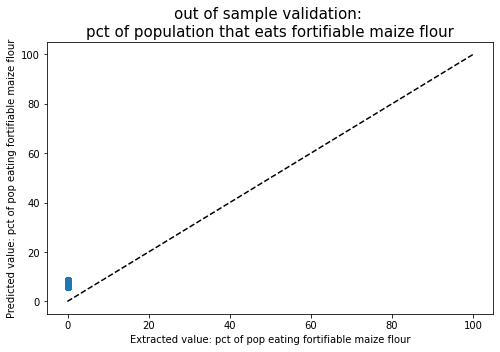

Kenya


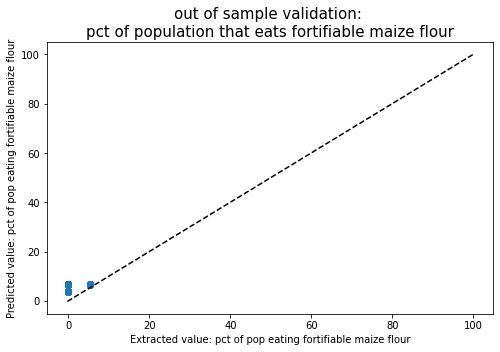

Mozambique


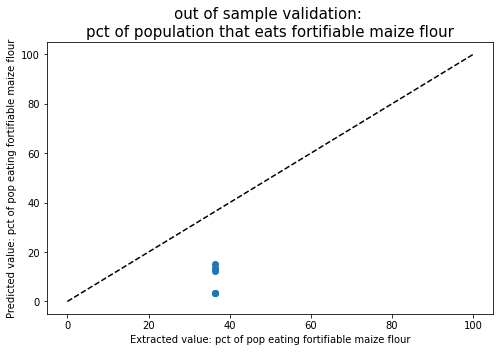

Nigeria


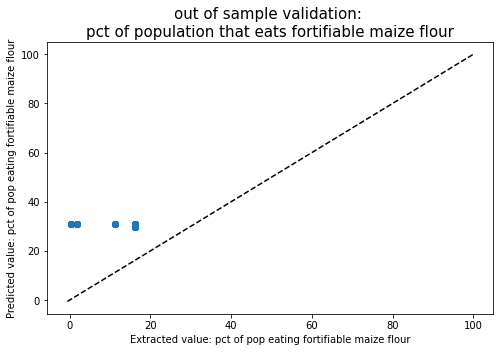

South Africa


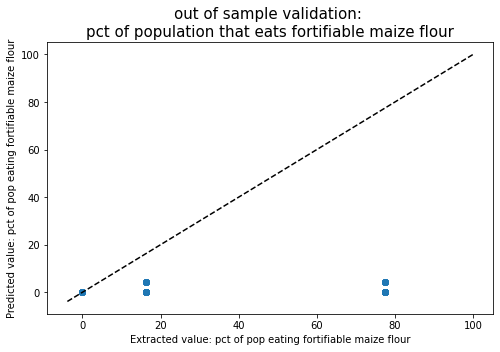

Uganda


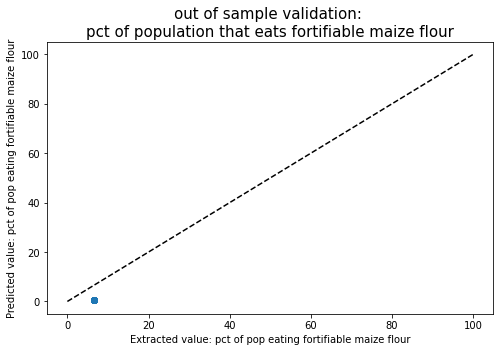

United Republic of Tanzania


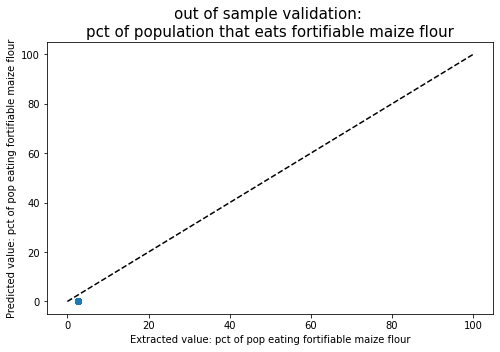

In [21]:
X, y, X_full, y_full, full_locs, notna_locs = setupReg(df, "maize flour", use_logit = False)

loc = np.unique(notna_locs)[0]
holdout, preds, reg = runReg(X, y, notna_locs, loc)

loc = np.unique(notna_locs)[0]
for loc in np.unique(notna_locs)[1:]:
    print(loc)
    holdout, preds, reg= runReg(X, y, notna_locs, loc)
    fig = plt.figure(figsize=(8,5))
    plotReg(preds, holdout, False, "maize flour")
    plt.show()

In [22]:
def estimate_nans(df, vehicle, use_logit, clip = True):
    
    # format for regression
    X, y, X_full, y_full, full_locs, notna_locs = setupReg(df, vehicle, use_logit = False)
    
    # run regression
    params = {'n_estimators': 800,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'lad'}
    
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X, y)
    
    # predict out
    preds = reg.predict(X_full)
    
    # populate missings with estimates
    y_full[np.isnan(y_full)] = preds[np.isnan(y_full)] 
    
    return y_full
    
#     if use_logit:
#         y_full = (expit(y_full) + shift) * 100
    
#     if clip:
#         y_full = np.clip(y_full, 0, 100)
    
#     return pd.DataFrame({'location_name':full_locs,'vehicle':vehicle,'percent_of_population_eating_vehicle':y_full})

In [23]:
def estimate_w_uncertainty(vehicle, n):
    X, y, X_full, y_full, full_locs, notna_locs = setupReg(df, vehicle, use_logit = False)
    
    estimates = np.vstack([estimate_nans(df, vehicle = vehicle, use_logit = False, clip = True) for i in range(n)])
    
    cols = [f'draw_{i}' for i in range(n)]

    out = pd.DataFrame(data = estimates.T, columns = cols)
    out['location_name'] = full_locs
    out['vehicle'] = vehicle
    
    return out[['location_name','vehicle'] + cols]

In [24]:
vehicle = 'maize flour'

In [27]:
%%time

maize_estimates = estimate_w_uncertainty(vehicle, 500)

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/share/code/beatrixh/miniconda/envs/stats/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

CPU times: user 9min 15s, sys: 694 ms, total: 9min 16s
Wall time: 9min 18s


In [28]:
save_maize_estimates = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/pct_eating_fortified_maize_regression_estimates_3_22_2021.csv'
maize_estimates.to_csv(save_maize_estimates, index = False)